<a href="https://colab.research.google.com/github/vilemknap/vk/blob/master/Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Linear Regression
https://github.com/vilemknap/PythonDataScienceHandbook/blob/master/notebooks/05.06-Linear-Regression.ipynb

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

## Simple Linear Regression

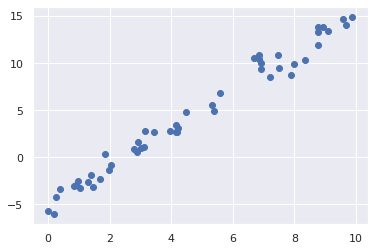

In [3]:

rng = np.random.RandomState(1)
x = 10 * rng.rand(50)
y = 2 * x - 5 + rng.randn(50)
plt.scatter(x, y);

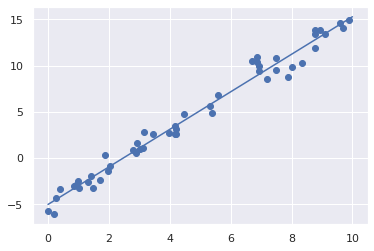

In [4]:
from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=True)

model.fit(x[:, np.newaxis], y)

xfit = np.linspace(0, 10, 1000)
yfit = model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit);

In [5]:
print("Model slope:    ", model.coef_[0])
print("Model intercept:", model.intercept_)

Model slope:     2.0272088103606953
Model intercept: -4.998577085553204


In [6]:

rng = np.random.RandomState(1)
X = 10 * rng.rand(100, 3)
y = 0.5 + np.dot(X, [1.5, -2., 1.])

model.fit(X, y)
print(model.intercept_)
print(model.coef_)

0.50000000000001
[ 1.5 -2.   1. ]



# Basis Function Regression
## Polynomial basis functions


In [9]:
from sklearn.preprocessing import PolynomialFeatures
x = np.array([2, 3, 4])
poly = PolynomialFeatures(3, include_bias=False)
poly.fit_transform(x[:, None])

array([[ 2.,  4.,  8.],
       [ 3.,  9., 27.],
       [ 4., 16., 64.]])

In [10]:
from sklearn.pipeline import make_pipeline
poly_model = make_pipeline(PolynomialFeatures(7),
                           LinearRegression())

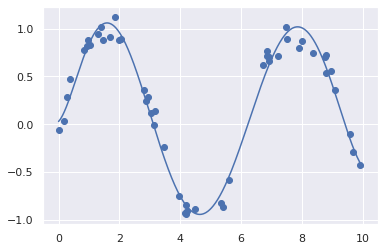

In [11]:
rng = np.random.RandomState(1)
x = 10 * rng.rand(50)
y = np.sin(x) + 0.1 * rng.randn(50)

poly_model.fit(x[:, np.newaxis], y)
yfit = poly_model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit);

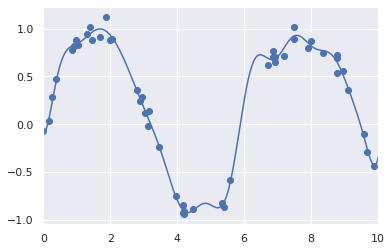

In [12]:
from sklearn.base import BaseEstimator, TransformerMixin

class GaussianFeatures(BaseEstimator, TransformerMixin):
    """Uniformly spaced Gaussian features for one-dimensional input"""
    
    def __init__(self, N, width_factor=2.0):
        self.N = N
        self.width_factor = width_factor
    
    @staticmethod
    def _gauss_basis(x, y, width, axis=None):
        arg = (x - y) / width
        return np.exp(-0.5 * np.sum(arg ** 2, axis))
        
    def fit(self, X, y=None):
        # create N centers spread along the data range
        self.centers_ = np.linspace(X.min(), X.max(), self.N)
        self.width_ = self.width_factor * (self.centers_[1] - self.centers_[0])
        return self
        
    def transform(self, X):
        return self._gauss_basis(X[:, :, np.newaxis], self.centers_,
                                 self.width_, axis=1)
    
gauss_model = make_pipeline(GaussianFeatures(20),
                            LinearRegression())
gauss_model.fit(x[:, np.newaxis], y)
yfit = gauss_model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit)
plt.xlim(0, 10);

# Regularization
The introduction of basis functions into our linear regression makes the model much more flexible, but it also can very quickly lead to over-fitting (refer back to Hyperparameters and Model Validation for a discussion of this). For example, if we choose too many Gaussian basis functions, we end up with results that don't look so good:


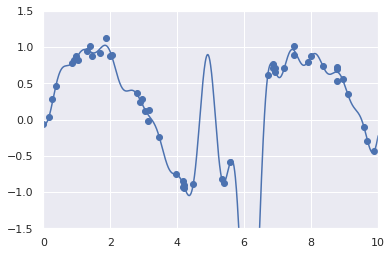

In [13]:
model = make_pipeline(GaussianFeatures(30),
                      LinearRegression())
model.fit(x[:, np.newaxis], y)

plt.scatter(x, y)
plt.plot(xfit, model.predict(xfit[:, np.newaxis]))

plt.xlim(0, 10)
plt.ylim(-1.5, 1.5);


With the data projected to the 30-dimensional basis, the model has far too much flexibility and goes to extreme values between locations where it is constrained by data. We can see the reason for this if we plot the coefficients of the Gaussian bases with respect to their locations:

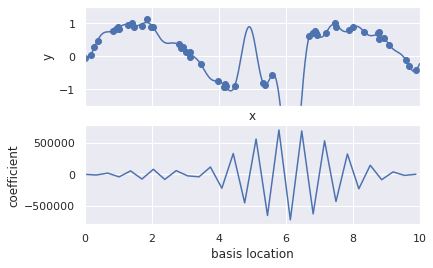

In [14]:
def basis_plot(model, title=None):
    fig, ax = plt.subplots(2, sharex=True)
    model.fit(x[:, np.newaxis], y)
    ax[0].scatter(x, y)
    ax[0].plot(xfit, model.predict(xfit[:, np.newaxis]))
    ax[0].set(xlabel='x', ylabel='y', ylim=(-1.5, 1.5))
    
    if title:
        ax[0].set_title(title)

    ax[1].plot(model.steps[0][1].centers_,
               model.steps[1][1].coef_)
    ax[1].set(xlabel='basis location',
              ylabel='coefficient',
              xlim=(0, 10))
    
model = make_pipeline(GaussianFeatures(30), LinearRegression())
basis_plot(model)

The lower panel of this figure shows the amplitude of the basis function at each location. This is typical over-fitting behavior when basis functions overlap: the coefficients of adjacent basis functions blow up and cancel each other out. We know that such behavior is problematic, and it would be nice if we could limit such spikes expliticly in the model by penalizing large values of the model parameters. Such a penalty is known as regularization, and comes in several forms.

## Ridge regression ($L_2$ Regularization)

Perhaps the most common form of regularization is known as ridge regression or $L_2$ regularization, sometimes also called Tikhonov regularization. This proceeds by penalizing the sum of squares (2-norms) of the model coefficients; in this case, the penalty on the model fit would be
image.png

where $\alpha$ is a free parameter that controls the strength of the penalty. This type of penalized model is built into Scikit-Learn with the Ridge estimator:




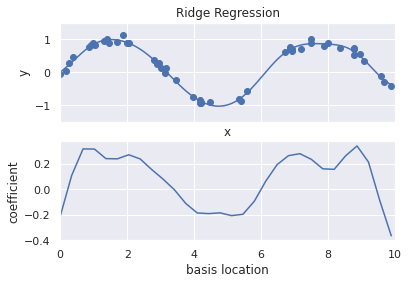

In [19]:
from sklearn.linear_model import Ridge
model = make_pipeline(GaussianFeatures(30), Ridge(alpha=0.1))
basis_plot(model, title='Ridge Regression')

The $\alpha$ parameter is essentially a knob controlling the complexity of the resulting model. In the limit $\alpha \to 0$, we recover the standard linear regression result; in the limit $\alpha \to \infty$, all model responses will be suppressed. One advantage of ridge regression in particular is that it can be computed very efficiently—at hardly more computational cost than the original linear regression model.

## Lasso regression ($L_1$ regularization)

Another very common type of regularization is known as lasso, and involves penalizing the sum of absolute values (1-norms) of regression coefficients:$$
P = \alpha\sum_{n=1}^N |\theta_n|
$$Though this is conceptually very similar to ridge regression, the results can differ surprisingly: for example, due to geometric reasons lasso regression tends to favor sparse models where possible: that is, it preferentially sets model coefficients to exactly zero.

We can see this behavior in duplicating the ridge regression figure, but using L1-normalized coefficients:

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002135815870488944, tolerance: 0.002065280097246271
  positive)


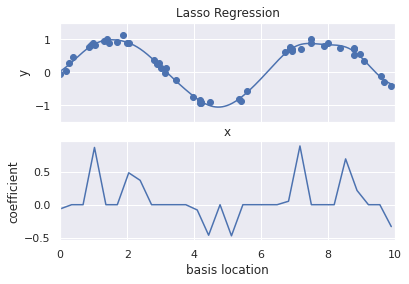

In [21]:
from sklearn.linear_model import Lasso
model = make_pipeline(GaussianFeatures(30), Lasso(alpha=0.001))
basis_plot(model, title='Lasso Regression')


With the lasso regression penalty, the majority of the coefficients are exactly zero, with the functional behavior being modeled by a small subset of the available basis functions. As with ridge regularization, the $\alpha$ parameter tunes the strength of the penalty, and should be determined via, for example, cross-validation (refer back to Hyperparameters and Model Validation for a discussion of this).

#Example: Predicting Bicycle Traffic


In [46]:
import pandas as pd
import io
import requests
url="https://data.seattle.gov/api/views/65db-xm6k/rows.csv?accessType=DOWNLOAD"
s=requests.get(url).content
counts=pd.read_csv(io.StringIO(s.decode('utf-8')), index_col='Date', parse_dates=True)

In [48]:
url2="https://www.ncei.noaa.gov/orders/cdo/2368896.csv"
s=requests.get(url2).content
weather=pd.read_csv(io.StringIO(s.decode('utf-8')), index_col='DATE', parse_dates=True)


In [49]:
daily = counts.resample('d').sum()
daily['Total'] = daily.sum(axis=1)
daily = daily[['Total']] # remove other columns

We saw previously that the patterns of use generally vary from day to day; let's account for this in our data by adding binary columns that indicate the day of the week:



In [50]:
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
for i in range(7):
    daily[days[i]] = (daily.index.dayofweek == i).astype(float)

Similarly, we might expect riders to behave differently on holidays; let's add an indicator of this as well:



In [51]:
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays('2012', '2016')
daily = daily.join(pd.Series(1, index=holidays, name='holiday'))
daily['holiday'].fillna(0, inplace=True)

In [52]:
daily['holiday']

Date
2012-10-03    0.0
2012-10-04    0.0
2012-10-05    0.0
2012-10-06    0.0
2012-10-07    0.0
             ... 
2020-10-27    0.0
2020-10-28    0.0
2020-10-29    0.0
2020-10-30    0.0
2020-10-31    0.0
Freq: D, Name: holiday, Length: 2951, dtype: float64

We also might suspect that the hours of daylight would affect how many people ride; let's use the standard astronomical calculation to add this information:



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  after removing the cwd from sys.path.


(8.0, 17.0)

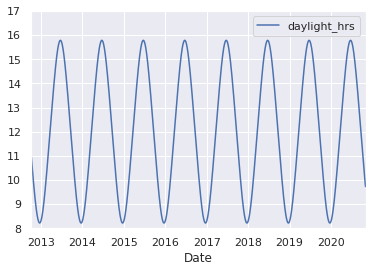

In [53]:

def hours_of_daylight(date, axis=23.44, latitude=47.61):
    """Compute the hours of daylight for the given date"""
    days = (date - pd.datetime(2000, 12, 21)).days
    m = (1. - np.tan(np.radians(latitude))
         * np.tan(np.radians(axis) * np.cos(days * 2 * np.pi / 365.25)))
    return 24. * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180.

daily['daylight_hrs'] = list(map(hours_of_daylight, daily.index))
daily[['daylight_hrs']].plot()
plt.ylim(8, 17)


We can also add the average temperature and total precipitation to the data. In addition to the inches of precipitation, let's add a flag that indicates whether a day is dry (has zero precipitation):

In [58]:
weather

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,AWND,PGTM,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,WDF2,WDF5,WSF2,WSF5,WT01,WT02,WT03,WT08,Temp (C),dry day
DATE,,,,,,,,,,,,,,,,,,,,,,,
2020-01-01,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",47.4444,-122.3138,112.8,14.32,NaN,0.000000e+00,0.0,0.0,51.0,0.53,0.46,220.0,220.0,25.1,33.1,NaN,NaN,NaN,NaN,0.495,1
2020-01-02,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",47.4444,-122.3138,112.8,9.17,NaN,3.255007e-06,0.0,0.0,45.0,0.50,0.41,180.0,170.0,19.9,27.1,1.0,NaN,NaN,NaN,0.455,0
2020-01-03,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",47.4444,-122.3138,112.8,9.62,NaN,6.045012e-06,0.0,0.0,48.0,0.62,0.46,220.0,220.0,28.0,38.9,1.0,NaN,NaN,1.0,0.540,0
2020-01-04,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",47.4444,-122.3138,112.8,14.09,NaN,1.550003e-06,0.0,0.0,47.0,0.46,0.40,210.0,190.0,30.0,38.0,1.0,NaN,NaN,NaN,0.430,0
2020-01-05,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",47.4444,-122.3138,112.8,14.32,NaN,2.170004e-06,0.0,0.0,44.0,0.48,0.42,200.0,200.0,25.9,33.1,1.0,NaN,NaN,NaN,0.450,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-18,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",47.4444,-122.3138,112.8,10.96,1546.0,6.045012e-06,0.0,0.0,48.0,0.49,0.44,190.0,200.0,28.0,33.1,1.0,NaN,NaN,NaN,0.465,0
2020-11-19,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",47.4444,-122.3138,112.8,NaN,NaN,2.480005e-06,0.0,0.0,45.0,0.48,0.42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.450,0
2020-11-20,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",47.4444,-122.3138,112.8,NaN,NaN,1.550003e-07,0.0,0.0,46.0,0.50,0.43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.465,0


In [61]:
# temperatures are in 1/10 deg C; convert to C
weather['TMIN'] /= 10
weather['TMAX'] /= 10
weather['Temp (C)'] = 0.5 * (weather['TMIN'] + weather['TMAX'])

# precip is in 1/10 mm; convert to inches
weather['PRCP'] /= 254
weather['dry day'] = (weather['PRCP'] == 0).astype(int)

daily = daily.merge(weather[['PRCP', 'Temp (C)', 'dry day']])

Finally, let's add a counter that increases from day 1, and measures how many years have passed. This will let us measure any observed annual increase or decrease in daily crossings:



In [62]:
daily['annual'] = (daily.index - daily.index[0]).days / 365.


IndexError: ignored

In [63]:
daily.head()


,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,PRCP,Temp (C),dry day,annual
